# <span style="color:green;">Step 0</span><br>
### <span style="color:lightgreen;">Install and clean data from binance</span><br>

In [ ]:
!pip install pmdarima optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.2/259.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, SimpleRNN
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from scipy.interpolate import interp1d
import warnings
import plotly.graph_objects as go
import numpy as np
import optuna
from functools import partial
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 6)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Useful functions

In [ ]:
def splitted_cross_validation_setup(series, n_splits):
    length = len(series)
    window_size = length // (n_splits + 1)
    divided = []

    for i in range(1, n_splits+1):
        if i == n_splits:
            sample = series
        else:
            sample = series[:window_size * (i + 1)]

        train_end = window_size * i
        test_start = train_end
        test_end = test_start + window_size

        train = sample[:train_end]
        test = sample[test_start:test_end]

        divided.append((train, test))

    return divided

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


def create_lagged_features(data, lag=10):
    """
    Create lagged features for a univariate time series.
    :param data: A pandas Series or array of time series values
    :param lag: Number of lagged time steps to include
    :return: Features (X) and targets (y) for supervised learning
    """
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    X = np.array(X)
    y = np.array(y)
    return X, y

def create_model_CNN(filters, kernel_size):
    model = keras.Sequential([
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(10, 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
    return model

def create_model_RNN(units, dropout_rate):
    model = keras.Sequential([
        layers.SimpleRNN(units=units, input_shape=(10, 1)),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
    return model

def create_model_LSTM(units, dropout_rate):
    model = keras.Sequential([
        layers.LSTM(units=units, input_shape=(10, 1)),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
    return model

def objective(trial, model_type, X_train, y_train):
    if model_type == 'CNN':
        filters = trial.suggest_int('filters', 15, 128)
        kernel_size = trial.suggest_int('kernel_size', 2, 7)
        model = create_model_CNN(filters, kernel_size)
    elif model_type == 'RNN':
        units = trial.suggest_int('units', 1, 12)
        dropout_rate = trial.suggest_int('dropout_rate', 0.1, 0.5)
        model = create_model_RNN(units, dropout_rate)
    else:
        units = trial.suggest_int('units', 1, 12)
        dropout_rate = trial.suggest_int('dropout_rate', 0.1, 0.5)
        model = create_model_LSTM(units, dropout_rate)

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    score = model.evaluate(X_train, y_train, verbose=0)
    return score[0]

# <span style="color:green;">Step 1</span><br>
### <span style="color:lightgreen;">Data analysis:</span>


Data overview: our data consists of more than 2000 csv files of historical data of all almost all cryptocurrencies which are present on platform Binance. The last observed value in each file was made in 2024-11-17 (November 17). The interval of each observation is 1 day.

The construction of files:
- time: the start of trading period started.
- open: the price of the asset when given period started.
- high: the highest price the asset reached during given period.
- low: the lowest price the asset reached during given period.
- close: the price of the asset when given period ended.
- volume: the total amount of the asset that was traded during given period, represented in the amount of coins.
- close_time: time when the given period was ended.
- quote_asset_volume: the total value of all trades during given period, measured in the quote currency (USD).
- number_of_trades: the total number of trades executed during given period.
- taker_buy_base_asset: the amount of the asset was bought by aggressive buyers (market orders), represented in the amount of coins.
- taker_buy_quote_asset: the total value of those aggressive buys, measured in the quote currency (USD).

**The duration of each period is 1 day**

First, we're going to introduce you to the data by showing you some graphs related to the Bitcoin coin. It will be a good representative of its kind.

In [ ]:
btc_df = pd.read_csv('BTCUSDT.csv').drop("Unnamed: 0", axis=1)
btc_df

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset,taker_buy_quote_asset
0,2022-02-22 02:00:00,37008.16,38429.00,36350.00,38230.33,53785.945890,2022-02-23 01:59:59.999,2.010628e+09,1212527,27322.735750,1.021948e+09
1,2022-02-23 02:00:00,38230.33,39249.93,37036.79,37250.01,43560.732000,2022-02-24 01:59:59.999,1.665487e+09,1030872,21449.955800,8.206399e+08
2,2022-02-24 02:00:00,37250.02,39843.00,34322.28,38327.21,120476.294580,2022-02-25 01:59:59.999,4.335107e+09,2622780,60103.131400,2.164377e+09
3,2022-02-25 02:00:00,38328.68,39683.53,38014.37,39219.17,56574.571250,2022-02-26 01:59:59.999,2.197890e+09,1408558,29904.015890,1.161437e+09
4,2022-02-26 02:00:00,39219.16,40348.45,38573.18,39116.72,29361.256800,2022-02-27 01:59:59.999,1.152622e+09,924257,14658.935960,5.758522e+08
...,...,...,...,...,...,...,...,...,...,...,...
995,2024-11-13 02:00:00,87952.00,93265.64,86127.99,90375.20,86763.854127,2024-11-14 01:59:59.999,7.790929e+09,11962100,44342.329327,3.983690e+09
996,2024-11-14 02:00:00,90375.21,91790.00,86668.21,87325.59,56729.510860,2024-11-15 01:59:59.999,5.073861e+09,9828858,27940.856000,2.499213e+09
997,2024-11-15 02:00:00,87325.59,91850.00,87073.38,91032.07,47927.950680,2024-11-16 01:59:59.999,4.276239e+09,8009111,24800.610870,2.213154e+09
998,2024-11-16 02:00:00,91032.08,91779.66,90056.17,90586.92,22717.876890,2024-11-17 01:59:59.999,2.067959e+09,4239455,11496.313660,1.046687e+09


**Candlestick plot for BTC**

In [ ]:
fig = go.Figure(data=[
    go.Candlestick(
        x=btc_df["time"],
        open=btc_df["open"],
        high=btc_df["high"],
        low=btc_df["low"],
        close=btc_df["close"]
    )
])

fig.update_layout(
    title="Candlestick Chart for BTC/USDT",
    xaxis_title="Time",
    yaxis_title="Price",
    template="plotly_dark"
)

fig.show()

This chart visualizes the candlestick plot for BTC/USDT. It represents the value of coin in given period. Each rectangle represents one trading period (in our case 1 day)

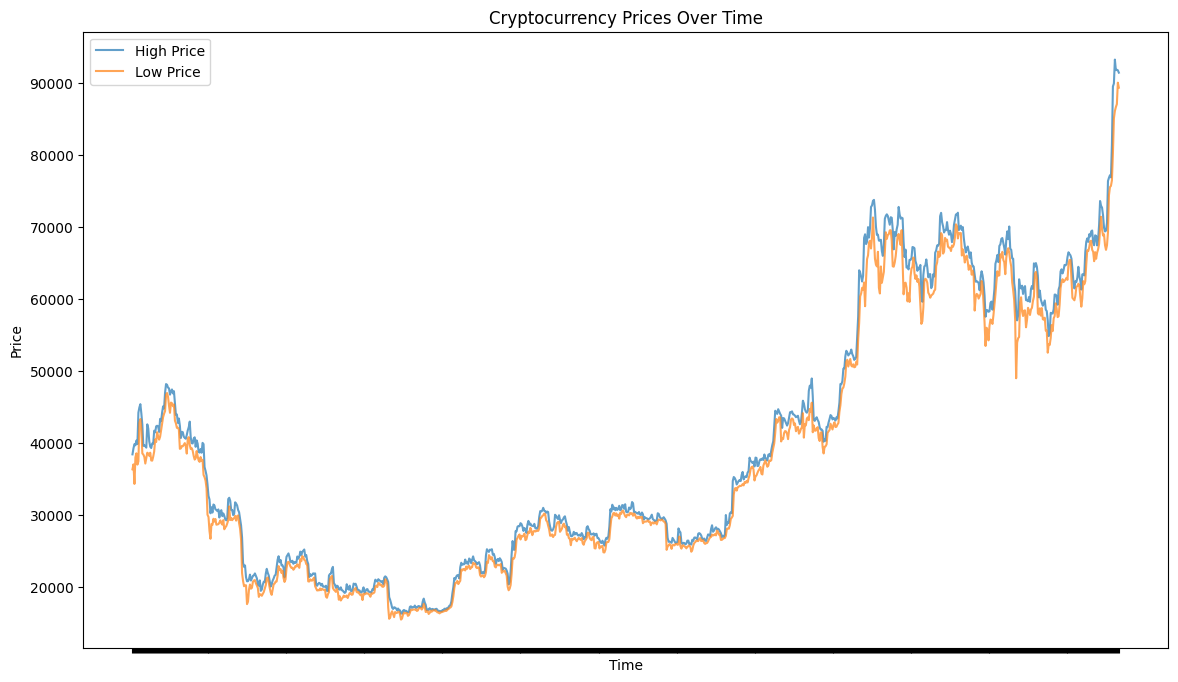

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(btc_df['time'], btc_df['high'], label='High Price', alpha=0.7)
plt.plot(btc_df['time'], btc_df['low'], label='Low Price', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Cryptocurrency Prices Over Time')
plt.tick_params(axis='x', labelbottom=False)
plt.legend()
plt.show()


It is simpler representation of previous plot.

The blue line represents the highest price reached during each interval, while the orange line shows the lowest price. It highlights significant price volatility with sharp peaks and troughs, particularly in 2024, indicating active market fluctuations.

We also can see that fluctuations by creating a volume graphic

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=btc_df["time"],
    y=btc_df["quote_asset_volume"],
    name="Quote Asset Volume (USD)",
    marker_color='orange'
))

fig.update_layout(
    title="Quote Asset Volume",
    xaxis_title="Date",
    yaxis_title="Volume (USD)",
    template="plotly_dark"
)

fig.show()

This chart shows the trading volume of a cryptocurrency over time. The bars indicate periods of heightened trading activity, likely due to market events or increased interest. Overall, trading volume fluctuates significantly.

Now, when we know what our data is about we can plot the pie chart of volumes (in a day) of all collected coins.

In [ ]:
all_df = []
all_files = os.listdir("./data")
symbols = []

for file in all_files:
    symbol = file.split(".")[0]

    symbol_df = pd.read_csv("./data/" + file).drop("Unnamed: 0", axis=1)
    symbol_df['symbol'] = symbol

    all_df.append(symbol_df)
    symbols.append(symbol)

FileNotFoundError: [Errno 2] No such file or directory: './data'

In [ ]:
import plotly.graph_objects as go

volumes_last_observed = [(df['quote_asset_volume'].iloc[-1], df['symbol'].iloc[-1]) for df in all_df]
volumes_last_observed.sort(key= lambda x: x[0], reverse=True)

top_20_and_others = volumes_last_observed[:20] + [(sum((ele[0] for ele in volumes_last_observed[:20])), 'Others')]

fig = go.Figure(data=[go.Pie(
    labels=[ele[1] for ele in top_20_and_others],
    values=[ele[0] for ele in top_20_and_others],
    hole=0.3
    )])

fig.update_layout(
    title="Asset Volume Distribution of 10 Coins",
    template="plotly_dark",
    margin=dict(t=40, b=40, l=40, r=40)
)

fig.show()


As we can see, the USDT/TRY pair has the largest volume because Tether (USDT) is a widely used stablecoin.

# <span style="color:green;">Part 2</span><br>
### <span style="color:lightgreen;">Creating math models for price predictions</span>

For our predicitons we will use BTC, because it is the most expensive and famous coin.

## <span style="color:lightgreen;">Predicting</span>
### <span style="color:lightgreen;">Sarimax</span>

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is a time series forecasting model. It combines trends, seasonality, and relationships with external factors (exogenous variables) to make accurate predictions. It’s often used in finance, sales, and economics.

Why Hyperparameters Matter:
Hyperparameters (like p, d, q for ARIMA components and P, D, Q, s for seasonal parts) define the model structure:
- p/q: Control the influence of past data (lags).
- d/D: Handle data differencing to make it stationary.
- s: Captures seasonality cycles.

Tuning these parameters ensures the model fits the data well, improving forecasting accuracy. Without proper tuning, predictions may either underfit or overfit the data.

Libraries like pmdarima provide auto_arima() functions that automate finding the best combination of parameters using cross-validation and model selection criteria like AIC (Akaike Information Criterion).

Now let's find the best params for SARIMA

In [ ]:
model = auto_arima(btc_df['close'], exogenous=None, seasonal=True, m=12, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=17146.428, Time=2.84 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=17744.521, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=17430.463, Time=0.28 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=17148.382, Time=1.61 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=17145.450, Time=3.40 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=17145.427, Time=2.56 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=17145.298, Time=1.83 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=17145.903, Time=5.20 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=17147.795, Time=10.72 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=17148.756, Time=1.24 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=inf, Time=2.91 sec
 ARIMA(3,2,2)(1,0,0)[12]             : AIC=inf, Time=4.04 sec
 ARIMA(2,2,3)(1,0,0)[12]             : AIC=17147.455, Time=7.59 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,2,3)(1,0,0)[1

Great as we can see best parametres are ((2, 2, 2), (1, 0, 0, 12))

In [ ]:
best_params = ((2, 2, 2), (1, 0, 0, 12))
colors = ['red', 'orange', 'yellow', 'green', 'blue']

splitted = splitted_cross_validation_setup(btc_df, 5)
all_mse = []
data = []

for ind, (train_df, test_df) in enumerate(splitted):
    train = train_df['close']
    model = SARIMAX(train, order=best_params[0], seasonal_order=best_params[1]).fit(disp=False)
    forecast_steps = len(test_df)
    y_pred = model.get_forecast(steps=forecast_steps)

    predicted_mean = y_pred.predicted_mean
    pred_index = pd.date_range(start=train_df['time'].iloc[-1], periods=forecast_steps, freq='D')
    all_mse.append(mse(test_df['close'], predicted_mean))

    trace_predicted = go.Scatter(
        x=pred_index,
        y=predicted_mean,
        mode='lines',
        name='Predicted Prices',
        line=dict(color=colors[ind])
    )
    data.append(trace_predicted)

trace_actual = go.Scatter(
    x=btc_df['close_time'],
    y=btc_df['close'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='black')
)

layout = go.Layout(
    title='BTC/USDT Price Prediction for Next Month',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
    legend=dict(title='Legend', x=1, y=1),
    template="plotly_white"
)

data.append(trace_actual)

fig = go.Figure(data=data, layout=layout)

print("Average MSE: ", np.array(all_mse).mean())
fig.show()

Average MSE:  86112671.9926859


As we can see the MSE is very big and plot representation also not very accurate, so SARIMA model is not a good choice for crypto predictions.

### <span style="color:lightgreen;">ARIMA</span>

The ARIMA (AutoRegressive Integrated Moving Average) model is a popular time series forecasting method. It focuses on capturing three main components:

AR (AutoRegressive): Uses past values to predict future ones.
I (Integrated): Makes data stationary by differencing.
MA (Moving Average): Accounts for past forecast errors.
It’s effective for datasets with trends and patterns but not seasonality (unless paired with SARIMA/SARIMAX).

### Decompose Data

Decomposing a time series breaks it into components: trend, seasonality, and residuals. This helps:
- Understand the underlying patterns.
- Confirm if the data is stationary (required for ARIMA).
- Identify if differencing or transformations are needed before modeling.
- In short, clean and decomposed data sets a strong foundation for reliable ARIMA predictions!

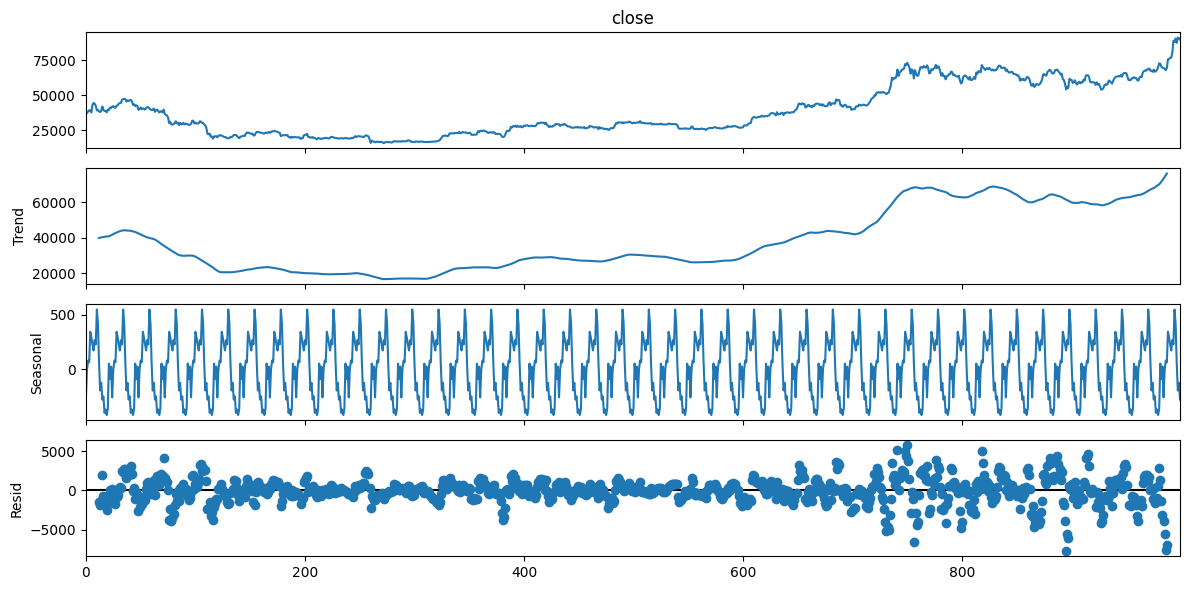

In [ ]:
decomposed = seasonal_decompose(btc_df['close'], model='add', period=24)
decomposed.plot()
plt.tight_layout()
plt.show()

resid = decomposed.resid[6:-6]
season = decomposed.seasonal[6:-6]
trend = decomposed.trend[6:-6]


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=btc_df['close_time'][12:-12],
    y=btc_df['close'][12:-12],
    mode='lines',
    name='BTC Close',
))

fig.add_trace(go.Scatter(
    x=btc_df['close_time'][6:-6],
    y=resid + trend,
    mode='lines',
    name='Resid + Trend',
    line=dict(color='orange')
))

fig.update_layout(
    title="BTC/USDT Price and Residuals + Trend",
    xaxis_title="Time",
    yaxis_title="Price",
    template="plotly_white",
    legend_title="Legend"
)

fig.show()

Let's run Arima with random parametrs

In [ ]:
splitted = splitted_cross_validation_setup(btc_df, 5)
all_mse = []
data = []

for ind, (train_df, test_df) in enumerate(splitted):
    train = train_df['close']
    model = ARIMA(train, order=(5, 2, 4)).fit()
    forecast_steps = len(test_df)
    y_pred = model.get_forecast(steps=forecast_steps)

    predicted_mean = y_pred.predicted_mean
    pred_index = pd.date_range(start=train_df['time'].iloc[-1], periods=forecast_steps, freq='D')
    all_mse.append(mse(test_df['close'], predicted_mean))

    trace_predicted = go.Scatter(
        x=pred_index,
        y=predicted_mean,
        mode='lines',
        name='Predicted Prices',
        line=dict(color=colors[ind])
    )
    data.append(trace_predicted)

trace_actual = go.Scatter(
    x=btc_df['close_time'],
    y=btc_df['close'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='black')
)

layout = go.Layout(
    title='BTC/USDT Price Prediction for Next Month',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
    legend=dict(title='Legend', x=1, y=1),
    template="plotly_white"
)

data.append(trace_actual)

fig = go.Figure(data=data, layout=layout)

print("Average MSE: ", np.array(all_mse).mean())
fig.show()


Average MSE:  88127330.76035812


Again, ARIMA with random parameters shows very bad results. Now we will try to find the best params for ARIMA and make a prediction.

In [ ]:

auto_model = auto_arima(
    btc_df['close'],
    seasonal=False,
    stepwise=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    max_d=2,
    max_order=None
)

best_order = auto_model.order
best_order


 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=17746.519, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=17151.194, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=17147.646, Time=0.13 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=17435.135, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=17150.035, Time=0.20 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=17345.024, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=17147.070, Time=0.33 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1

(3, 2, 3)

Now let's rerun model

In [ ]:
order = (3,2,3)

splitted = splitted_cross_validation_setup(btc_df, 5)
all_mse = []
data = []

for ind, (train_df, test_df) in enumerate(splitted):
    train = train_df['close']
    model = ARIMA(train, order=order).fit()
    forecast_steps = len(test_df)
    y_pred = model.get_forecast(steps=forecast_steps)

    predicted_mean = y_pred.predicted_mean
    pred_index = pd.date_range(start=train_df['time'].iloc[-1], periods=forecast_steps, freq='D')
    all_mse.append(mse(test_df['close'], predicted_mean))

    trace_predicted = go.Scatter(
        x=pred_index,
        y=predicted_mean,
        mode='lines',
        name='Predicted Prices',
        line=dict(color=colors[ind])
    )
    data.append(trace_predicted)

trace_actual = go.Scatter(
    x=btc_df['close_time'],
    y=btc_df['close'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='black')
)

layout = go.Layout(
    title='BTC/USDT Price Prediction for Next Month',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
    legend=dict(title='Legend', x=1, y=1),
    template="plotly_white"
)

data.append(trace_actual)

fig = go.Figure(data=data, layout=layout)

print("Average MSE: ", np.array(all_mse).mean())
fig.show()


Average MSE:  88905017.47418585


Again, not very accurate predictions.

## <span style="color:lightgreen;">Exponential Smoothing</span>

This code applies the Exponential Smoothing (ETS) method to forecast the next 30 days of the detrended time series data. The ETS model uses an additive trend with no seasonality to capture the underlying patterns in the data. The resulting forecast is visualized alongside the historical detrended data for better interpretation.

In [ ]:
decomposition = seasonal_decompose(btc_df['close'], model='additive', period=365)
trend = decomposition.trend
trend.index = btc_df['close_time']
seasonal = decomposition.seasonal
seasonal.index = btc_df['close_time']
residual = decomposition.resid
residual.index = btc_df['close_time']
detrended_data = residual.dropna()

In [ ]:
ets_model = ExponentialSmoothing(
    detrended_data,
    trend='additive',
    seasonal=None,
    damped_trend=False
).fit()

fig = go.Figure()
ets_forecast = ets_model.forecast(steps=30)


fig.add_trace(go.Scatter(
    x=detrended_data.index,
    y=detrended_data.values,
    mode='lines',
    name='Detrended Data',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=pd.date_range(start=detrended_data.index[-1], periods=30, freq='D'),
    y=ets_forecast,
    mode='lines',
    name='ETS Forecast',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Exponential Smoothing Forecast',
    xaxis_title='Time',
    yaxis_title='Value',
    legend=dict(
        title='Legend',
        x=0.1,
        y=1.1,
        orientation='h'
    ),
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()

Let's make it to our real chart

In [ ]:
trend_notna = trend.dropna()
trend_extrapolate = interp1d(
    range(len(trend_notna.index)),
    trend_notna.values,
    fill_value="extrapolate"
)
future_trend_indices = [
    range(len(trend_notna.index), len(trend_notna.index) + 30)
]
trend_forecast = trend_extrapolate(future_trend_indices)
seasonal_forecast = seasonal[-365:].values[:30]
recomposed_forecast = ets_forecast.values + trend_forecast + seasonal_forecast

In [ ]:
trend_notna = trend.dropna()
trend_extrapolate = interp1d(
    range(len(trend_notna.index)),
    trend_notna.values,
    fill_value="extrapolate"
)
future_trend_indices = [
    range(len(trend_notna.index), len(trend_notna.index) + 30)
]
trend_forecast = trend_extrapolate(future_trend_indices)
seasonal_forecast = seasonal[-365:].values[:30]
recomposed_forecast = ets_forecast.values + trend_forecast + seasonal_forecast

forecast_dates = pd.date_range(start=btc_df['time'].iloc[-1], periods=30, freq='D')
recomposed_forecast_df = pd.DataFrame({
    'time': forecast_dates,
    'forecast': recomposed_forecast.reshape(-1)
})

btc_df.index = btc_df['close_time']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=btc_df.index,
    y=btc_df['close'],
    mode='lines',
    name='BTC chart',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=[str(ele) for ele in pd.date_range(start=btc_df['time'].iloc[-1], periods=30, freq='D')],
    y=recomposed_forecast_df['forecast'],
    mode='lines',
    name='ETS Forecast',
    line=dict(color='red')
))

fig.update_layout(
    title='BTCUSDT Exponential smoothing',
    xaxis_title='Time',
    yaxis_title='Value',
    legend=dict(
        title='Legend',
        x=0.1,
        y=1.1,
        orientation='h'
    ),
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


As we can see, the recomposed forecast indicates slight price stabilization with minimal fluctuations in the short term. This suggests no significant price movement is expected, making it a less attractive for investment.

## <span style="color:lightgreen;">Prophet model forecast</span>

This code uses Facebook Prophet, a time series forecasting tool, to predict the next 30 days based on detrended historical data. The detrended dataset is reformatted to match Prophet's input requirements, and the model is trained on this data. After training, a future dataframe is generated for prediction, and the results are visualized, showing both the historical detrended data and the forecasted values. Prophet is particularly useful for capturing trends and seasonality in time series data.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/lh/rd5kzgf52pv46_540yq0yf380000gn/T/tmpwzq5aify/ynd7hzow.json
DEBUG:cmdstanpy:input tempfile: /var/folders/lh/rd5kzgf52pv46_540yq0yf380000gn/T/tmpwzq5aify/0q3e1qyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28583', 'data', 'file=/var/folders/lh/rd5kzgf52pv46_540yq0yf380000gn/T/tmpwzq5aify/ynd7hzow.json', 'init=/var/folders/lh/rd5kzgf52pv46_540yq0yf380000gn/T/tmpwzq5aify/0q3e1qyq.json', 'output', 'file=/var/folders/lh/rd5kzgf52pv46_540yq0yf380000gn/T/tmpwzq5aify/prophet_modelj6f2ix2v/prophet_model-20241118055205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chai

                         ds         yhat
636 2024-05-21 02:59:59.999  2719.384224
637 2024-05-22 02:59:59.999  2510.677967
638 2024-05-23 02:59:59.999  2646.354949
639 2024-05-24 02:59:59.999  2647.530833
640 2024-05-25 02:59:59.999  2700.866042
641 2024-05-26 02:59:59.999  2607.765352
642 2024-05-27 02:59:59.999  2608.637456
643 2024-05-28 02:59:59.999  2837.057458
644 2024-05-29 02:59:59.999  2628.351201
645 2024-05-30 02:59:59.999  2764.028183
646 2024-05-31 02:59:59.999  2765.204066
647 2024-06-01 02:59:59.999  2818.539275
648 2024-06-02 02:59:59.999  2725.438586
649 2024-06-03 02:59:59.999  2726.310689
650 2024-06-04 02:59:59.999  2954.730691
651 2024-06-05 02:59:59.999  2746.024435
652 2024-06-06 02:59:59.999  2881.701416
653 2024-06-07 02:59:59.999  2882.877300
654 2024-06-08 02:59:59.999  2936.212509
655 2024-06-09 02:59:59.999  2843.111820
656 2024-06-10 02:59:59.999  2843.983923
657 2024-06-11 02:59:59.999  3072.403925
658 2024-06-12 02:59:59.999  2863.697669
659 2024-06-13 0

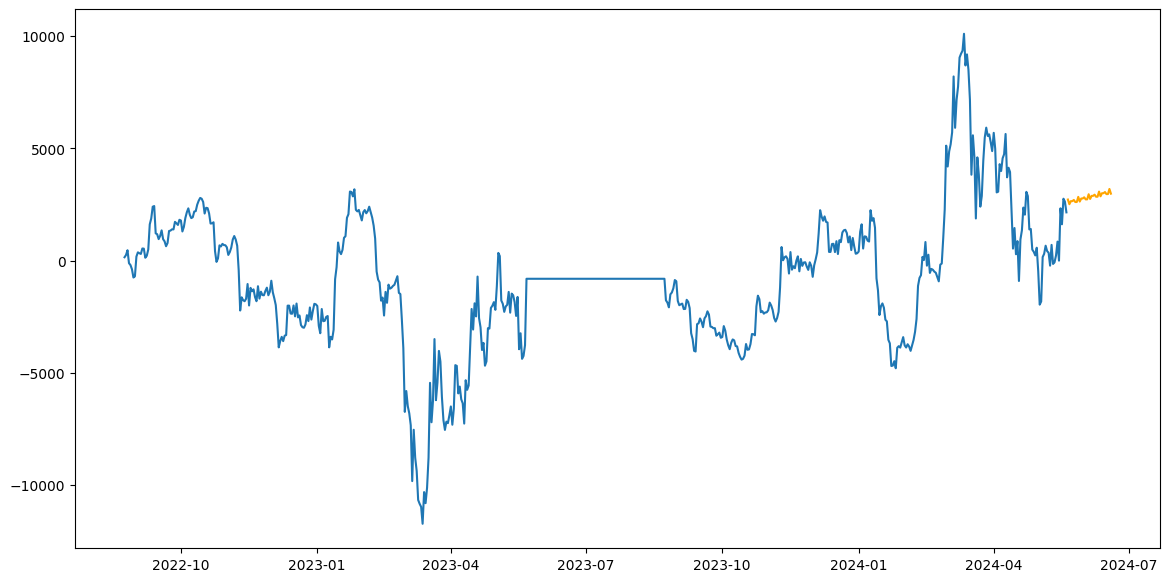

In [ ]:

detrended_df = detrended_data.reset_index().rename(columns={'close_time': 'ds', 'resid': 'y'})

detrended_df = detrended_df.dropna()
detrended_df['ds'] = pd.to_datetime(detrended_df['ds'])
prophet_model = Prophet()
prophet_model.fit(detrended_df)
future_dates = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future_dates)
forecast = forecast[['ds', 'yhat']].tail(30)
print(forecast)

plt.figure(figsize=(14, 7))
plt.plot(detrended_df['ds'], detrended_df['y'], label='Historical Detrended Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Data', color='orange')


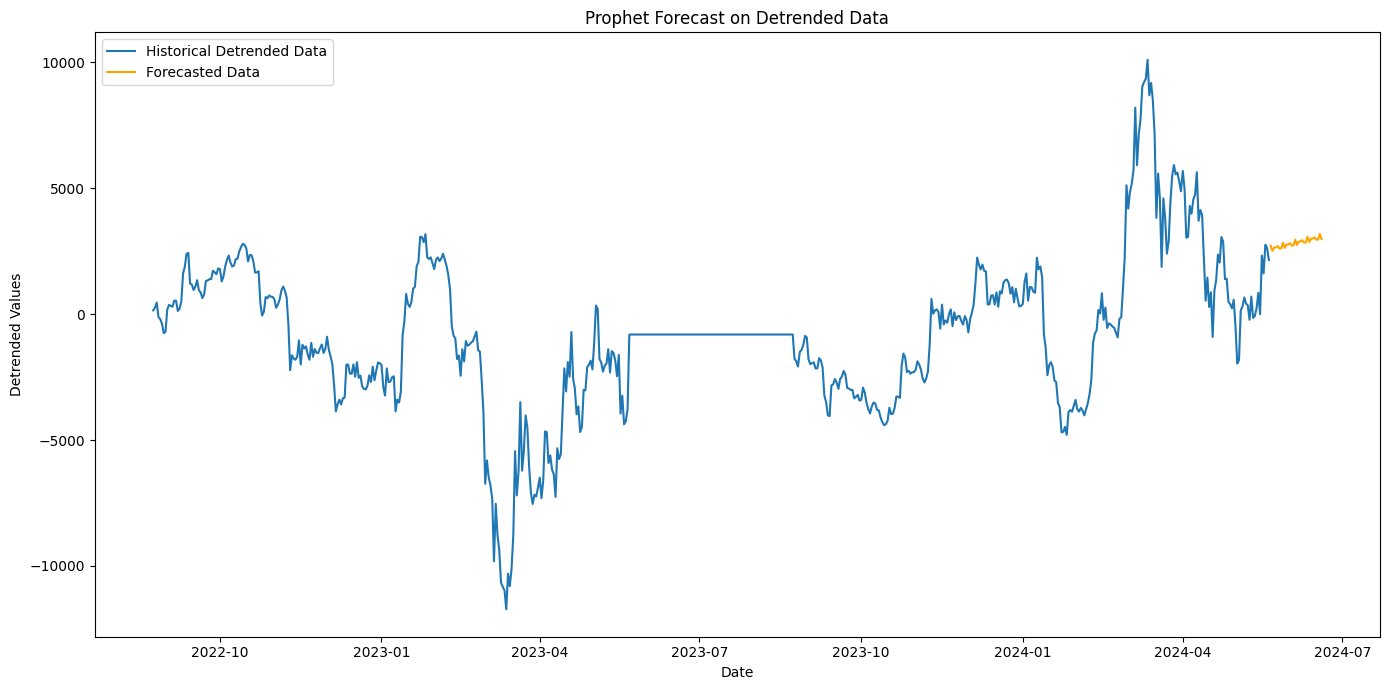

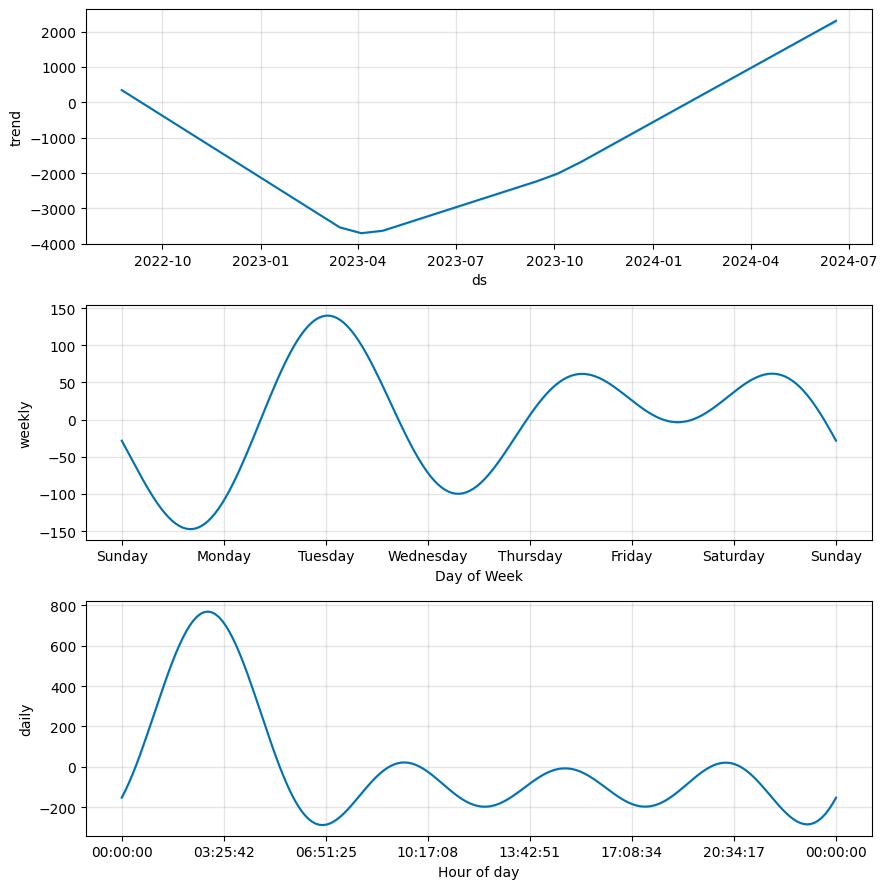

In [ ]:
forecast = prophet_model.predict(future_dates)

forecast_subset = forecast[['ds', 'yhat']].tail(30)
plt.figure(figsize=(14, 7))
plt.plot(detrended_df['ds'], detrended_df['y'], label='Historical Detrended Data')
plt.plot(forecast_subset['ds'], forecast_subset['yhat'], label='Forecasted Data', color='orange')
plt.title('Prophet Forecast on Detrended Data')
plt.xlabel('Date')
plt.ylabel('Detrended Values')
plt.legend()
plt.tight_layout()
plt.show()

prophet_model.plot_components(forecast)
plt.show()

As we can see, the forecasted data (in orange) shows a modest upward trend for the next 30 days, suggesting slight recovery or stabilization. This indicates cautious optimism but may not point to significant movement in the short term.

On data with trend:

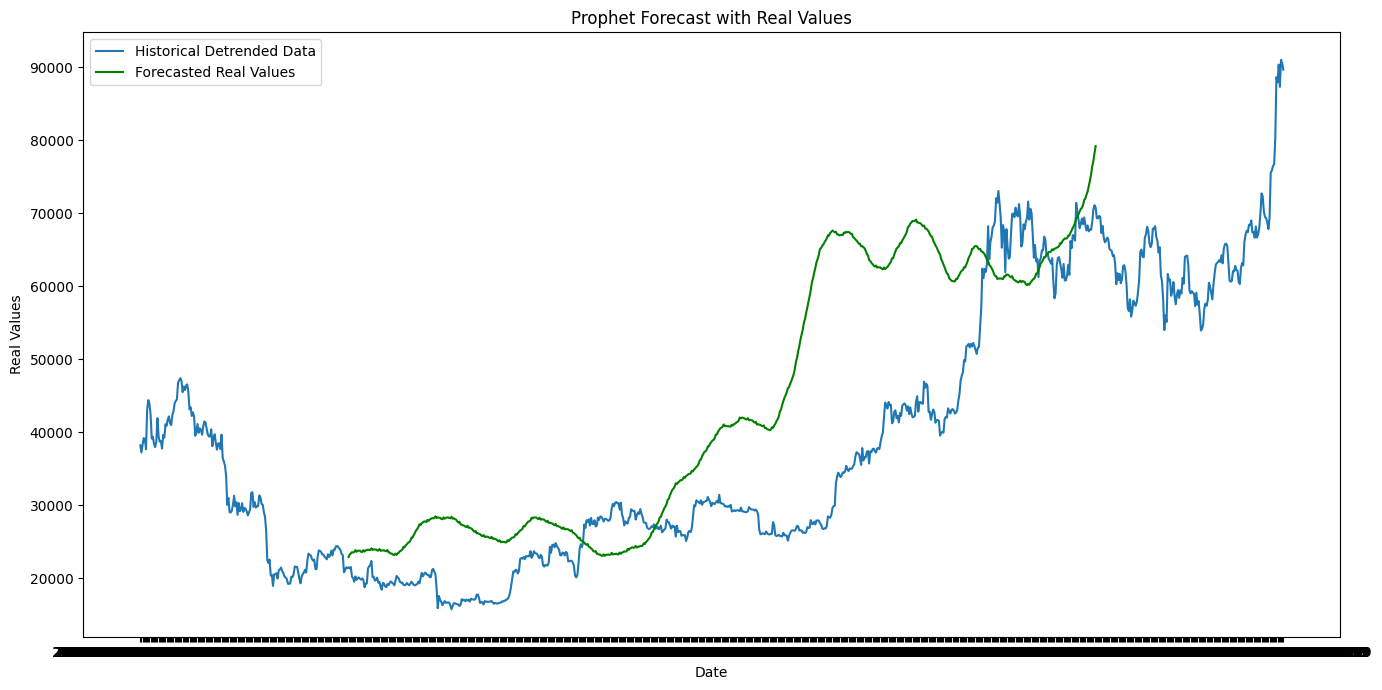

In [ ]:
forecast_with_trend = forecast.copy()
forecast_with_trend['yhat_real'] = forecast['yhat'] + decomposed.trend[-len(forecast):].values

# Plot the real forecasted values
plt.figure(figsize=(14, 7))
plt.plot(btc_df['close'], label='Historical Detrended Data')
plt.plot(forecast_with_trend['ds'].astype("str"), forecast_with_trend['yhat_real'], label='Forecasted Real Values', color='green')
plt.title('Prophet Forecast with Real Values')
plt.xlabel('Date')
plt.ylabel('Real Values')
plt.legend()
plt.tight_layout()
plt.show()


As we can see, the green forecasted values indicate potential price movements based on historical trends. While it aligns with general trends, there are deviations, suggesting the model captures major movements but may not perfectly predict smaller fluctuations.

## <span style="color:lightgreen;">Linear Regression model</span>

This code trains a Linear Regression model to predict the closing price (close) of BNB based on selected features, such as trading volume and the number of trades. After training, the model generates predictions for the closing price, which are compared against the actual values using a scatter plot. The red dashed line represents a perfect prediction, helping visualize the accuracy of the model. This approach evaluates how well the selected features explain variations in the closing price

<function matplotlib.pyplot.show(close=None, block=None)>

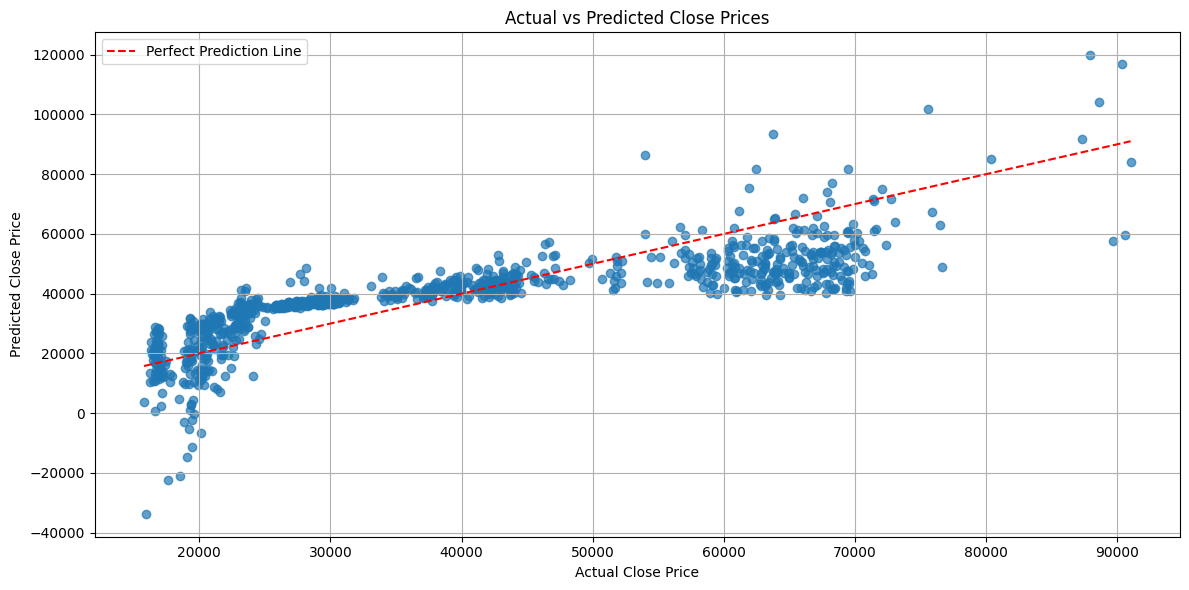

In [ ]:
features = ['quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset', 'taker_buy_quote_asset']
target = 'close'

X = btc_df[features]
y = btc_df[target]
model = LinearRegression()
model.fit(X, y)
btc_df['predicted_close'] = model.predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(btc_df[target], btc_df['predicted_close'], alpha=0.7)
plt.plot([btc_df[target].min(), btc_df[target].max()],
            [btc_df[target].min(), btc_df[target].max()],
            color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show


As we can see, the predicted close prices (blue points) show a moderate alignment with the actual close prices. However, there is noticeable scatter, indicating the model is not perfectly accurate. The red dashed line, representing perfect predictions, highlights the deviation of the predictions, suggesting room for improvement in feature selection or model complexity.

## <span style="color:lightgreen;">AI models</span>

## <span style="color:lightgreen;">LSTM forecast</span>

This code utilizes a Long Short-Term Memory (LSTM) neural network, a type of recurrent neural network (RNN), to forecast the next 30 days of detrended time series data. The create_lagged_features function generates lagged features to provide temporal context for the model. The LSTM is trained using these lagged features, capturing sequential dependencies and patterns in the data, making it well-suited for time series forecasting.

In [ ]:
lag = 10
X, y = create_lagged_features(detrended_data.values, lag)

X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential([
    LSTM(5, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

forecast_lstm = model.predict(X[-30:])
print("LSTM Forecast:", forecast_lstm)


Epoch 1/50


2024-11-18 05:53:41.821505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 6s 191ms/step - loss: 10010715.0000
Epoch 2/50
20/20 [==============================] - 3s 148ms/step - loss: 9917011.0000
Epoch 3/50
20/20 [==============================] - 3s 132ms/step - loss: 9837585.0000
Epoch 4/50
20/20 [==============================] - 3s 128ms/step - loss: 9764130.0000
Epoch 5/50
20/20 [==============================] - 3s 132ms/step - loss: 9690869.0000
Epoch 6/50
20/20 [==============================] - 3s 133ms/step - loss: 9601388.0000
Epoch 7/50
20/20 [==============================] - 3s 140ms/step - loss: 9492572.0000
Epoch 8/50
20/20 [==============================] - 3s 156ms/step - loss: 9358959.0000
Epoch 9/50
20/20 [==============================] - 2s 123ms/step - loss: 9191440.0000
Epoch 10/50
20/20 [==============================] - 3s 144ms/step - loss: 8984094.0000
Epoch 11/50
20/20 [==============================] - 3s 134ms/step - loss: 8747369.0000
Epoch 12/50
20/20 [==============================] 

2024-11-18 05:55:46.558455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 454ms/step
LSTM Forecast: [[ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29220361e-01]
 [ 2.27901086e-01]
 [ 1.78405315e-01]
 [ 2.29339093e-01]
 [-2.56401703e+02]
 [-1.16119189e+03]
 [-1.44684167e+03]
 [-6.31313362e+01]
 [-5.16371107e+00]
 [ 2.29358628e-01]
 [ 2.28691071e-01]
 [ 2.25711599e-01]
 [-1.21238235e+02]
 [ 2.29360372e-01]
 [-8.04916992e+01]
 [-7.66725082e+01]
 [ 2.29359224e-01]
 [ 2.29360342e-01]
 [ 1.08531364e+02]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]
 [ 2.29360372e-01]]


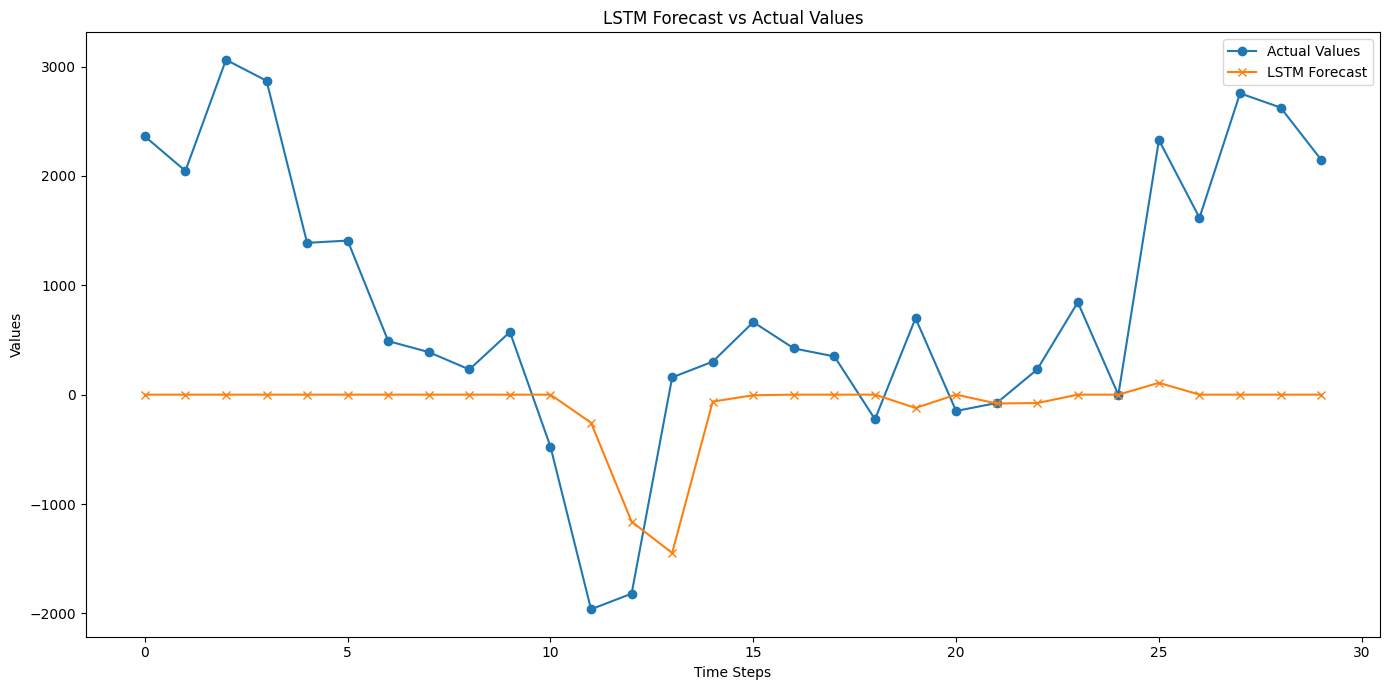

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(y[-30:])), y[-30:], label='Actual Values', marker='o')
plt.plot(range(len(forecast_lstm)), forecast_lstm, label='LSTM Forecast', marker='x')
plt.title('LSTM Forecast vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
plt.show()

As we can see, the LSTM forecast follows the actual values trend, indicating that the model captures patterns in the data effectively. While slight deviations exist, the overall trend alignment suggests the LSTM model is reliable for short-term predictions.

Let's try to tune and run it on our coin

In [ ]:
prt_objective = partial(objective, model_type="LSTM", X_train = X, y_train = y)

study = optuna.create_study(direction='minimize')
study.optimize(prt_objective, n_trials=20)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-18 05:55:47,187] A new study created in memory with name: no-name-e21b96ed-d016-4931-90b7-5353887bb165
2024-11-18 05:55:47.874717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 05:55:48.024823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 05:55:48.595304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 05:55:52.581905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 05:55:52.641161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2024-11-18 05:55:53,470] Trial 0 finished with value: 26031.890625 and parameters: {'units': 6, 'dropout_rat

Best trial:
  Value: -34975.25390625
  Params: 
    units: 12
    dropout_rate: 0


In [ ]:
from keras.optimizers import Adagrad
lag = 10
X, y = create_lagged_features(btc_df['close'].values, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    LSTM(12, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adagrad(0.01), loss='mse')
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

forecast_steps = 30
forecast_input = btc_df['close'].values[-lag:]
forecast_input = forecast_input.reshape((1, lag, 1))

predictions = []
for _ in range(forecast_steps):
    pred = model.predict(forecast_input)
    predictions.append(pred[0, 0])
    forecast_input = np.roll(forecast_input, -1, axis=1)
    forecast_input[0, -1, 0] = pred

start_time = btc_df.index[-1]
pred_index = [ str(ele) for ele in pd.date_range(start=start_time, periods=forecast_steps, freq='D') ]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=btc_df.index,
    y=btc_df['close'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=pred_index,
    y=predictions,
    mode='lines',
    name='Predicted Prices',
    line=dict(color='orange')
))

fig.update_layout(
    title='BTC/USDT Price Prediction for Next Month (LSTM)',
    xaxis_title='Time',
    yaxis_title='Price',
    legend=dict(title='Legend'),
    template='plotly_white'
)

fig.show()


Epoch 1/10


2024-11-18 06:00:53.512733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 6s 152ms/step - loss: 1833986304.0000
Epoch 2/10
31/31 [==============================] - 4s 126ms/step - loss: 1814217856.0000
Epoch 3/10
31/31 [==============================] - 4s 122ms/step - loss: 1808285184.0000
Epoch 4/10
31/31 [==============================] - 4s 123ms/step - loss: 1800071936.0000
Epoch 5/10
31/31 [==============================] - 4s 113ms/step - loss: 1780323840.0000
Epoch 6/10
31/31 [==============================] - 4s 122ms/step - loss: 1738420608.0000
Epoch 7/10
31/31 [==============================] - 4s 118ms/step - loss: 1668197376.0000
Epoch 8/10
31/31 [==============================] - 4s 122ms/step - loss: 1570588928.0000
Epoch 9/10
31/31 [==============================] - 4s 128ms/step - loss: 1448649856.0000
Epoch 10/10
1/1 [==============================] - 0s 190ms/step


2024-11-18 06:01:33.164934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 24ms/step


## <span style="color:lightgreen;">1dCNN forecast</span>

In [ ]:
prt_objective = partial(objective, model_type="CNN", X_train = X, y_train = y)

study = optuna.create_study(direction='minimize')
study.optimize(prt_objective, n_trials=20)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-18 06:01:49,315] A new study created in memory with name: no-name-937a958c-a487-4645-a9f4-de8d6d86159c
2024-11-18 06:01:49.727587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 06:01:53.617398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2024-11-18 06:01:54,207] Trial 0 finished with value: -2405648302080.0 and parameters: {'filters': 67, 'kernel_size': 4}. Best is trial 0 with value: -2405648302080.0.
2024-11-18 06:01:54.472520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 06:01:58.223245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2024-11-18 06:01:58,869] Trial 1 finished with value: -3765907226624.0 and parameters: {'fil

Best trial:
  Value: -6350373388288.0
  Params: 
    filters: 116
    kernel_size: 7


In [ ]:
lag = 10
X, y = create_lagged_features(btc_df['close'].values, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=116, kernel_size=7, activation='relu',
                     input_shape=(10, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

forecast_steps = 30
forecast_input = btc_df['close'].values[-lag:]
forecast_input = forecast_input.reshape((1, lag, 1))

predictions = []
for _ in range(forecast_steps):
    pred = model.predict(forecast_input)
    predictions.append(pred[0, 0])
    forecast_input = np.roll(forecast_input, -1, axis=1)
    forecast_input[0, -1, 0] = pred

start_time = btc_df.index[-1]
pred_index = [ str(ele) for ele in pd.date_range(start=start_time, periods=forecast_steps, freq='D') ]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=btc_df.index,
    y=btc_df['close'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=pred_index,
    y=predictions,
    mode='lines',
    name='Predicted Prices',
    line=dict(color='orange')
))

fig.update_layout(
    title='BTC/USDT Price Prediction for Next Month (LSTM)',
    xaxis_title='Time',
    yaxis_title='Price',
    legend=dict(title='Legend'),
    template='plotly_white'
)

fig.show()


Epoch 1/50
31/31 [==============================] - 9s 291ms/step - loss: 1143904768.0000
Epoch 2/50
31/31 [==============================] - 4s 118ms/step - loss: 968451776.0000
Epoch 3/50
31/31 [==============================] - 4s 120ms/step - loss: 785373440.0000
Epoch 4/50
31/31 [==============================] - 4s 120ms/step - loss: 602999360.0000
Epoch 5/50
31/31 [==============================] - 4s 118ms/step - loss: 432085568.0000
Epoch 6/50
31/31 [==============================] - 4s 129ms/step - loss: 284426816.0000
Epoch 7/50
31/31 [==============================] - 4s 123ms/step - loss: 169161712.0000
Epoch 8/50
31/31 [==============================] - 4s 121ms/step - loss: 90208872.0000
Epoch 9/50
31/31 [==============================] - 4s 120ms/step - loss: 16384240.0000
Epoch 10/50
31/31 [==============================] - 4s 117ms/step - loss: 6562510.0000
Epoch 11/50
31/31 [==============================] - 4s 115ms/step - loss: 10042333.0000
Epoch 12/50
31/31 [====

## <span style="color:lightgreen;">RNN forecast</span>

In [ ]:
prt_objective = partial(objective, model_type="RNN", X_train = X, y_train = y)

study = optuna.create_study(direction='minimize')
study.optimize(prt_objective, n_trials=5)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-18 06:07:02,254] A new study created in memory with name: no-name-cd60f200-fe1f-4d68-81b8-adfe3ec729b9
2024-11-18 06:07:03.045601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 06:07:21.803971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2024-11-18 06:07:23,599] Trial 0 finished with value: -587296.4375 and parameters: {'units': 1, 'dropout_rate': 0}. Best is trial 0 with value: -587296.4375.
2024-11-18 06:07:24.132099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-18 06:07:46.459040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[I 2024-11-18 06:07:47,883] Trial 1 finished with value: 594079.1875 and parameters: {'units': 7, 'dropou

Best trial:
  Value: -587296.4375
  Params: 
    units: 1
    dropout_rate: 0


In [ ]:
lag = 10
X, y = create_lagged_features(btc_df['close'].values, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(units=6, activation='relu', input_shape=(10, 1)))
model.add(Dropout(0))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

forecast_steps = 30
forecast_input = btc_df['close'].values[-lag:]
forecast_input = forecast_input.reshape((1, lag, 1))

predictions = []
for _ in range(forecast_steps):
    pred = model.predict(forecast_input)
    predictions.append(pred[0, 0])
    forecast_input = np.roll(forecast_input, -1, axis=1)
    forecast_input[0, -1, 0] = pred

start_time = btc_df.index[-1]
pred_index = [ str(ele) for ele in pd.date_range(start=start_time, periods=forecast_steps, freq='D') ]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=btc_df.index,
    y=btc_df['close'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=pred_index,
    y=predictions,
    mode='lines',
    name='Predicted Prices',
    line=dict(color='orange')
))

fig.update_layout(
    title='BTC/USDT Price Prediction for Next Month (LSTM)',
    xaxis_title='Time',
    yaxis_title='Price',
    legend=dict(title='Legend'),
    template='plotly_white'
)

fig.show()


Epoch 1/50


2024-11-18 06:08:59.666494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 4s 91ms/step - loss: 349250304.0000
Epoch 2/50
31/31 [==============================] - 2s 55ms/step - loss: 99560592.0000
Epoch 3/50
31/31 [==============================] - 2s 49ms/step - loss: 23908850.0000
Epoch 4/50
31/31 [==============================] - 2s 49ms/step - loss: 5359346.5000
Epoch 5/50
31/31 [==============================] - 1s 48ms/step - loss: 1979768.1250
Epoch 6/50
31/31 [==============================] - 1s 48ms/step - loss: 1535789.6250
Epoch 7/50
31/31 [==============================] - 2s 49ms/step - loss: 1493349.5000
Epoch 8/50
31/31 [==============================] - 2s 50ms/step - loss: 1490887.1250
Epoch 9/50
31/31 [==============================] - 1s 46ms/step - loss: 1491212.1250
Epoch 10/50
31/31 [==============================] - 1s 48ms/step - loss: 1490584.0000
Epoch 11/50
31/31 [==============================] - 1s 45ms/step - loss: 1491061.2500
Epoch 12/50
31/31 [==============================] - 2s 50m

2024-11-18 06:10:15.648821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step


### NBEATS

In [ ]:
nb_df = pd.DataFrame()

nb_df['ds'] = pd.to_datetime(btc_df['close_time'])
nb_df['y'] = btc_df['close']
nb_df['unique_id'] = 0

model = NBEATS(
    h=24,
    input_size=48,
    stack_types=["seasonality"],
    activation="ReLU",
    num_lr_decays=2,
    scaler_type="robust",
    max_steps=1000,
    accelerator = "cpu",
    start_padding_enabled=True,
    val_check_steps=5,
    early_stop_patience_steps=5,
)

fcst = NeuralForecast(models=[model], freq="D")
fcst.fit(df=nb_df, val_size=2 * 220)
y_pred_nbeats = fcst.predict()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 863 K  | train
-------------------------------------------------------
860 K     Trainable params
3.3 K     Non-trainable params
863 K     Total params
3.454     Total estimated model params size (MB)
13        Modules in train mod

Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s, v_num=12, train_loss_step=2.870, train_loss_epoch=2.870, valid_loss=4.13e+3]


INFO: Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 305.06it/s]


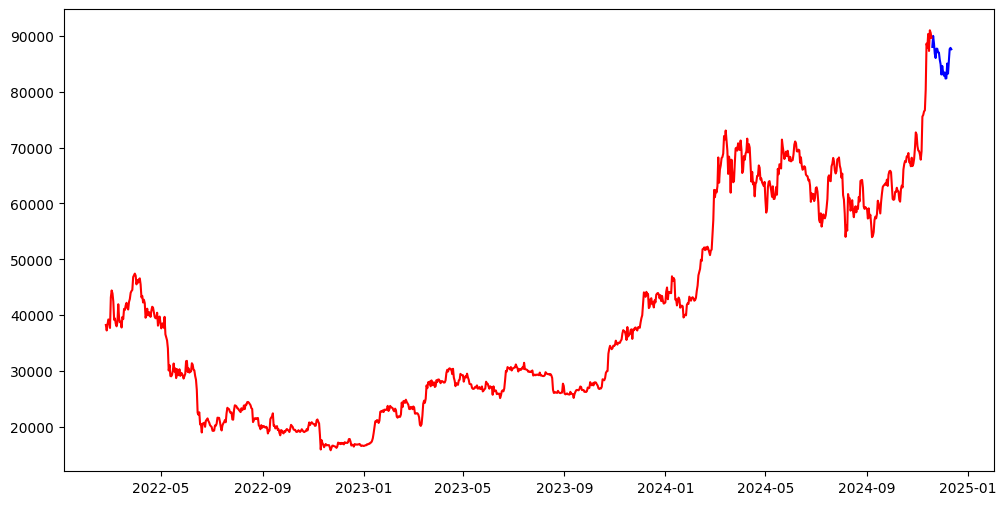

In [ ]:
plt.plot(y_pred_nbeats['ds'], y_pred_nbeats['NBEATS'], label="true", color="blue")
plt.plot(nb_df['ds'], nb_df['y'], label="true", color="red")

### TFT

In [ ]:
nf = NeuralForecast(
    models=[TFT(h=12, input_size=48,
                hidden_size=20,
                loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                learning_rate=0.005,
                max_steps=300,
                val_check_steps=10,
                accelerator = "cpu",
                early_stop_patience_steps=10,
                scaler_type='robust',
                windows_batch_size=None,
                enable_progress_bar=True),
    ],
    freq='D'
)
nf.fit(df=nb_df.iloc[:-120], val_size=120)

Y_hat_df = nf.predict(futr_df=nb_df.iloc[-120:])

Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 80     | train
4 | temporal_encoder        | TemporalCovariateEncoder | 15.9 K | train
5 | temporal

Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s, v_num=21, train_loss_step=8.740, train_loss_epoch=8.740, valid_loss=9.730]

INFO: Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.53it/s]


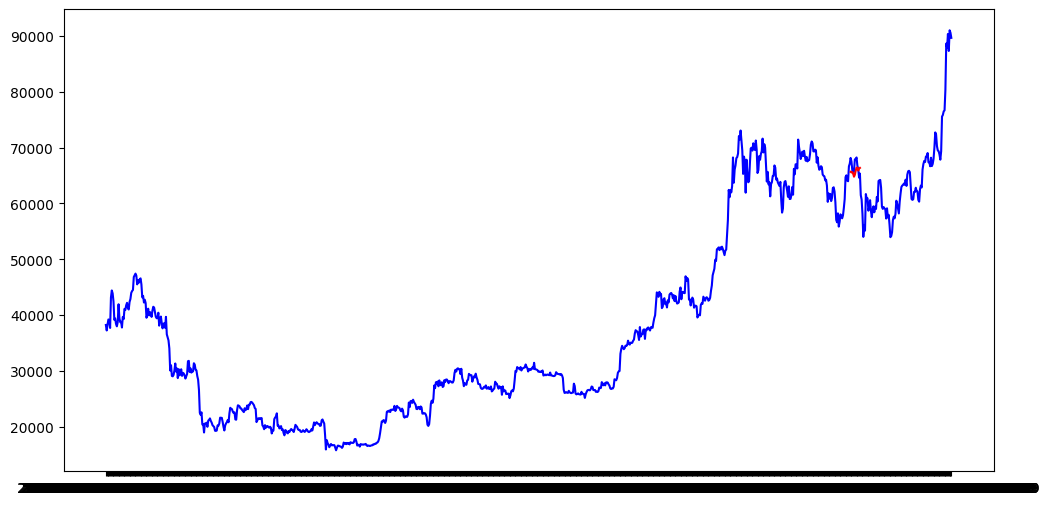

In [ ]:
plt.plot(nb_df['y'], label="1", color="blue")
plt.plot(nb_df['y'].index[-120:-108], Y_hat_df['TFT-median'], label="2", color="red")
plt.show()

TRansformers

In [ ]:
import pandas as pd

In [ ]:
eth_df = pd.read_csv('ETHUSDT.csv').drop("Unnamed: 0", axis=1)

In [ ]:
btc_df = pd.read_csv('BTCUSDT.csv').drop("Unnamed: 0", axis=1)

In [ ]:
df = pd.read_csv('ETHUSDT.csv').drop("Unnamed: 0", axis=1)

In [ ]:
columns_to_keep = ['time', 'close', 'quote_asset_volume']

df = df[columns_to_keep]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.preprocessing import MinMaxScaler

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')
df.set_index('time', inplace=True)

data = df['close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

look_back = 30
train_ratio = 0.8

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, look_back):
        self.data = data
        self.look_back = look_back
        self.length = len(data) - look_back

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx : idx+self.look_back]
        y = self.data[idx+self.look_back]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [ ]:
dataset = TimeSeriesDataset(data, look_back)
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

In [ ]:
class TransformerForecaster(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, look_back=30):
        super(TransformerForecaster, self).__init__()
        self.look_back = look_back
        self.d_model = d_model

        self.input_fc = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.output_fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)

        x = x.permute(1, 0, 2)

        encoded = self.transformer_encoder(x)
        last_step = encoded[-1, :, :]

        output = self.output_fc(last_step)
        return output.squeeze(-1)


In [ ]:
import numpy as np

In [ ]:
device = torch.device("cpu")
model = TransformerForecaster(look_back=look_back).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 32
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y.squeeze())
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/32, Train Loss: 0.1626, Val Loss: 0.0736
Epoch 2/32, Train Loss: 0.0298, Val Loss: 0.0122
Epoch 3/32, Train Loss: 0.0115, Val Loss: 0.0025
Epoch 4/32, Train Loss: 0.0071, Val Loss: 0.0018
Epoch 5/32, Train Loss: 0.0064, Val Loss: 0.0016
Epoch 6/32, Train Loss: 0.0050, Val Loss: 0.0013
Epoch 7/32, Train Loss: 0.0045, Val Loss: 0.0011
Epoch 8/32, Train Loss: 0.0038, Val Loss: 0.0009
Epoch 9/32, Train Loss: 0.0039, Val Loss: 0.0008
Epoch 10/32, Train Loss: 0.0034, Val Loss: 0.0008
Epoch 11/32, Train Loss: 0.0037, Val Loss: 0.0008
Epoch 12/32, Train Loss: 0.0035, Val Loss: 0.0007
Epoch 13/32, Train Loss: 0.0032, Val Loss: 0.0007
Epoch 14/32, Train Loss: 0.0028, Val Loss: 0.0009
Epoch 15/32, Train Loss: 0.0029, Val Loss: 0.0007
Epoch 16/32, Train Loss: 0.0024, Val Loss: 0.0007
Epoch 17/32, Train Loss: 0.0022, Val Loss: 0.0009
Epoch 18/32, Train Loss: 0.0020, Val Loss: 0.0007
Epoch 19/32, Train Loss: 0.0022, Val Loss: 0.0007
Epoch 20/32, Train Loss: 0.0019, Val Loss: 0.0012
Epoch 21/

In [ ]:
model.eval()

forecast_horizon = 30

recent_data = data[-look_back:].copy()

predictions_scaled = []

with torch.no_grad():
    for step in range(forecast_horizon):
        input_tensor = torch.tensor(recent_data, dtype=torch.float32, device=device).unsqueeze(0)

        next_val_scaled = model(input_tensor).item()

        predictions_scaled.append([next_val_scaled])

        recent_data = np.vstack([recent_data[1:], [next_val_scaled]])

predictions_scaled = np.array(predictions_scaled)
predictions = scaler.inverse_transform(predictions_scaled)

In [ ]:
last_date = df.index[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

forecast_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted_Close'])

In [ ]:
import plotly.graph_objects as go

In [ ]:

fig = go.Figure(data=[
    go.Candlestick(
        x=eth_df["time"],
        open=eth_df["open"],
        high=eth_df["high"],
        low=eth_df["low"],
        close=eth_df["close"],
        name="Historical Data"
    )
])

fig.add_trace(
    go.Scatter(
        x=forecast_df.index,
        y=forecast_df["Predicted_Close"],
        mode='lines+markers',
        name='Forecasted Close',
        line=dict(color='red', width=1),
        marker=dict(color='red', size=1)
    )
)

fig.update_layout(
    title="Candlestick Chart for BTC/USDT with Forecast",
    xaxis_title="Time",
    yaxis_title="Price",
    template="plotly_dark",
    hovermode="x unified"
)

fig.show()